# Lab 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import probplot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (10,5)
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv', low_memory=False)

In [3]:
data = data.loc[(data['product_id']=='Petrol 92')& (data['date']>= '2021-01-01')]
data['big_competitor_mean_price_relative'] = data['big_competitor_mean_price_relative'].replace({0:1})
data['not_big_competitor_mean_price_relative'] = data['not_big_competitor_mean_price_relative'].replace({0:1})

In [4]:
data.head()

,station_id,product_id,date,hour,price,volume,discount_bonusy_rub,month_num,weekday,quarter_num,...,year,region_name,station_size,location,station_type,n_competitors,trk,year_month,closeness_mean,closeness_sum
49850,15690,Petrol 92,2021-01-01,0,38.85,0.008537,12.87,1,4,21,...,2021,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,5.0,2021-01,349.304372,944105.74229
49851,15690,Petrol 92,2021-01-01,1,38.85,0.050732,100.74,1,4,21,...,2021,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,5.0,2021-01,349.304372,944105.74229
49852,15690,Petrol 92,2021-01-01,2,38.85,0.016802,15.00,1,4,21,...,2021,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,5.0,2021-01,349.304372,944105.74229
49853,15690,Petrol 92,2021-01-01,3,38.85,0.037042,60.00,1,4,21,...,2021,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,5.0,2021-01,349.304372,944105.74229
49854,15690,Petrol 92,2021-01-01,4,38.85,0.044356,131.46,1,4,21,...,2021,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,5.0,2021-01,349.304372,944105.74229


### Описание признаков

* station_id - номер станции, 
* product_id - тип нефтепродукта, 
* date - дата, 
* hour - час, 
* price - цена топлива, 
* volume - объем проданного топлива,
* discount_bonusy_rub - количество начисленных бонусов за покупку топлива, 
* month_num - номер месяца, 
* weekday - день недели, 
* quarter_num - номер квартала,
* covid_index - индекс ковида, 
* very_cold - очень холодная погода (1/0), 
* cold - холодная погода (1/0), 
* warm - теплая погода, 
* hour_downtime - простои , 
* discount - прямая скидка,
* trend - тренд, 
* yhat - прогноз профета, 
* is_holiday - праздничный день (1/0), 
* big_competitor_mean_price - средняя цена крупных конкурентов,
* not_big_competitor_mean_price - средняя цена некрупных конкурентов, 
* big_competitor_min_price - минимальная цена крупных конкурентов,
* not_big_competitor_min_price - минимальная цена некрупных конкурентов, 
* big_competitor_unique - количество крупных конкурентов,
* not_big_competitor_unique - количество некрупных конкурентов, 
* region_mean - средняя цена по региону,

Группа этих признаков расшифровывается по аналогии, только эти данные конкуремнам крупным и некрупным всего региона:
* big_competitor_mean_price_reserve,
* not_big_competitor_mean_price_reserve,
* big_competitor_min_price_reserve,
* not_big_competitor_min_price_reserve, 
* big_competitor_unique_reserve,
* not_big_competitor_unique_reserve, 
* cost - себестоимость топлива, 
* traf - трафик на АЗС (не надо использовать этот признак) ,

Отношение цены конкурентов к нашим ценам:
* big_competitor_mean_price_relative,
* not_big_competitor_mean_price_relative,
* big_competitor_min_price_relative,
* not_big_competitor_min_price_relative,
* big_competitor_mean_price_reserve_relative,
* not_big_competitor_mean_price_reserve_relative,
* big_competitor_min_price_reserve_relative,
* not_big_competitor_min_price_reserve_relative, 


* margin - отступ, 
* profit - доход,
* day - день, 
* year - год, 
* region_name - название региона, 
* station_size - размер станции, 
* location - расположение станции,
* station_type - тип станции, 
* n_competitors - кол-во конкурентов поблизости, 
* trk - количество пистолетов на АЗС, 
* year_month - год месяц, 
* closeness_mean - степень похожести станции на другие станции,
* closeness_sum- степень похожести станции на другие станции

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37822 entries, 49850 to 485329
Data columns (total 55 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   station_id                                      37822 non-null  int64  
 1   product_id                                      37822 non-null  object 
 2   date                                            37822 non-null  object 
 3   hour                                            37822 non-null  int64  
 4   price                                           37822 non-null  float64
 5   volume                                          37822 non-null  float64
 6   discount_bonusy_rub                             37822 non-null  float64
 7   month_num                                       37822 non-null  int64  
 8   weekday                                         37822 non-null  int64  
 9   quarter_num                       

For this lab you need subsample with 5-10 random variables, at least half of them should be described with continuous random variable type. Target variable should be continuous.

In [6]:
target_variable = 'volume'

variables = ['price', 
             'discount_bonusy_rub', 
             'trend', 
             'profit',
             'big_competitor_mean_price_relative', 
             'not_big_competitor_mean_price_relative ']

all_variables = ['volume',
                 'price', 
                 'discount_bonusy_rub', 
                 'trend', 
                 'profit',
                 'big_competitor_mean_price_relative',
                 'not_big_competitor_mean_price_relative']

## Step 1

You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV) .

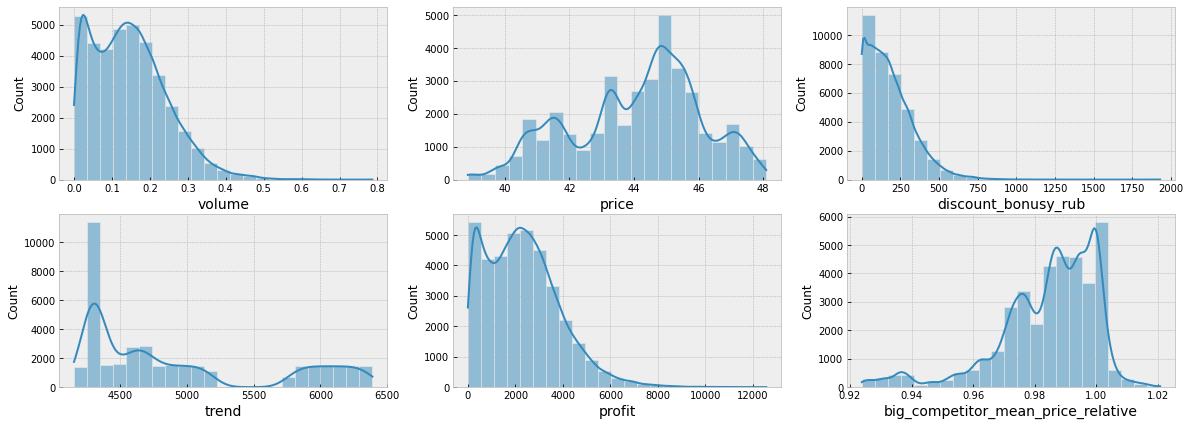

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 7))

for ax, cols in zip(axes.flat, all_variables):
    b = sns.histplot(data[cols], ax=ax, bins='doane',kde=True,)
    ax.set_xlabel(cols, fontsize=14)
plt.show()

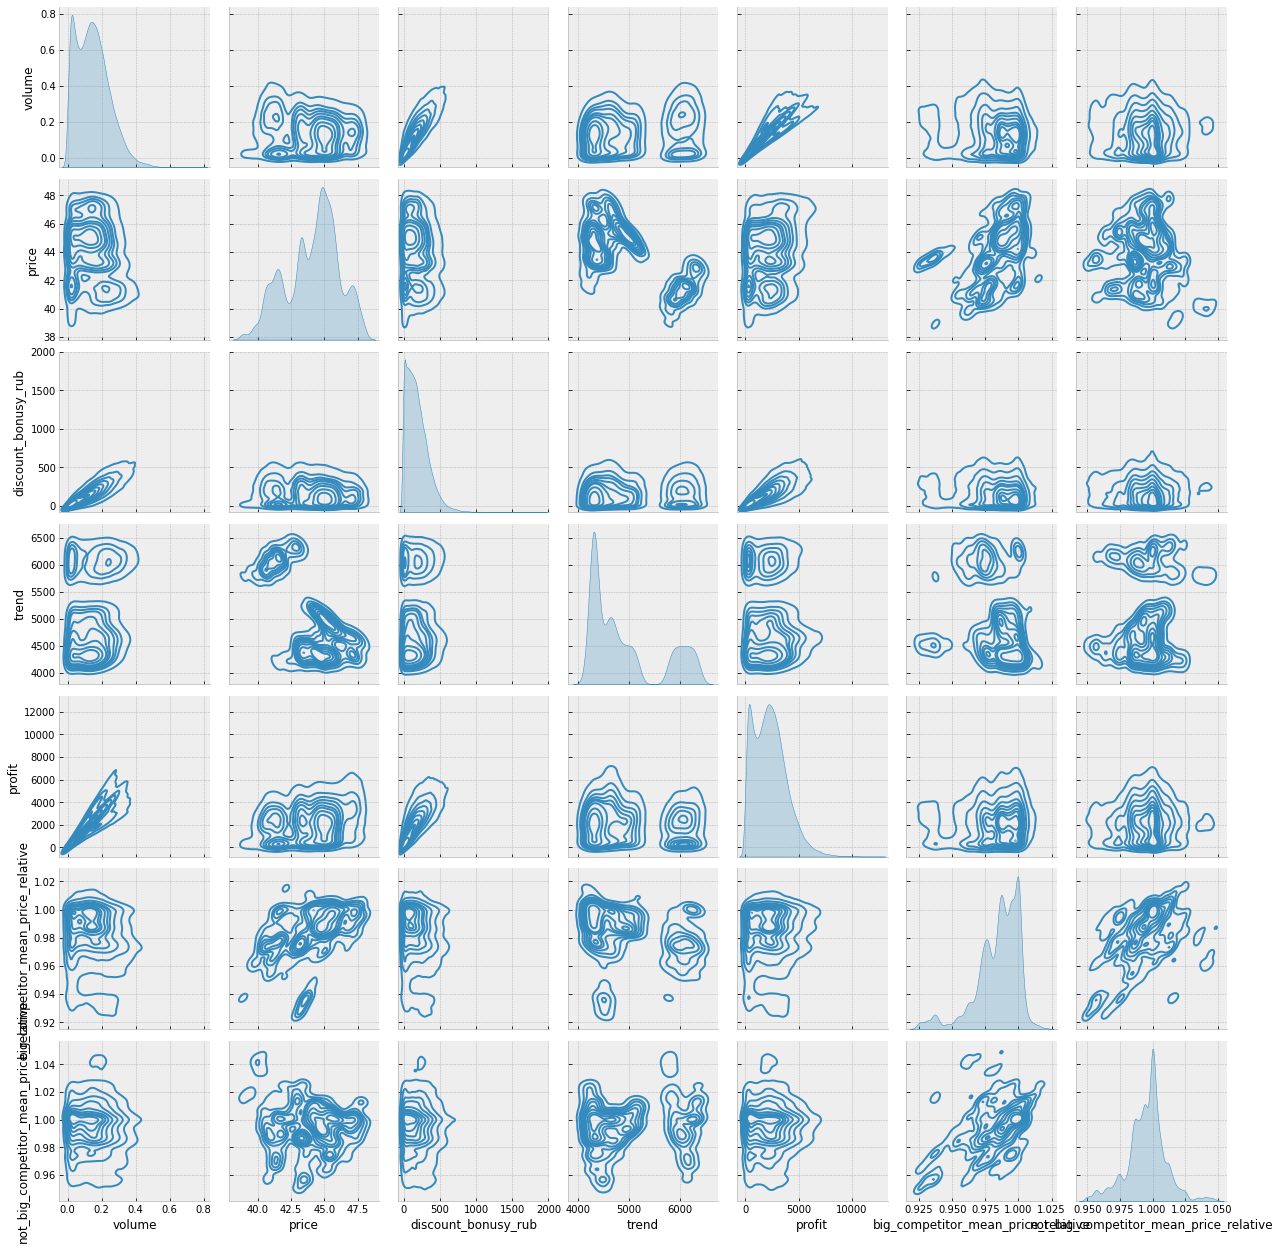

In [8]:
sns.pairplot(data[all_variables], kind='kde')
plt.show()

## Step 2

You need to make an estimation of multivariate mathematical expectation and variance.

In [9]:
data[all_variables].mean()

volume                                       0.146041
price                                       44.091193
discount_bonusy_rub                        182.396456
trend                                     4921.411025
profit                                    2306.226821
big_competitor_mean_price_relative           0.984260
not_big_competitor_mean_price_relative       0.995117
dtype: float64

In [10]:
data[all_variables].var()

volume                                    9.440443e-03
price                                     3.985064e+00
discount_bonusy_rub                       2.256060e+04
trend                                     5.050450e+05
profit                                    2.393570e+06
big_competitor_mean_price_relative        2.670686e-04
not_big_competitor_mean_price_relative    2.296998e-04
dtype: float64

## Step 3

You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

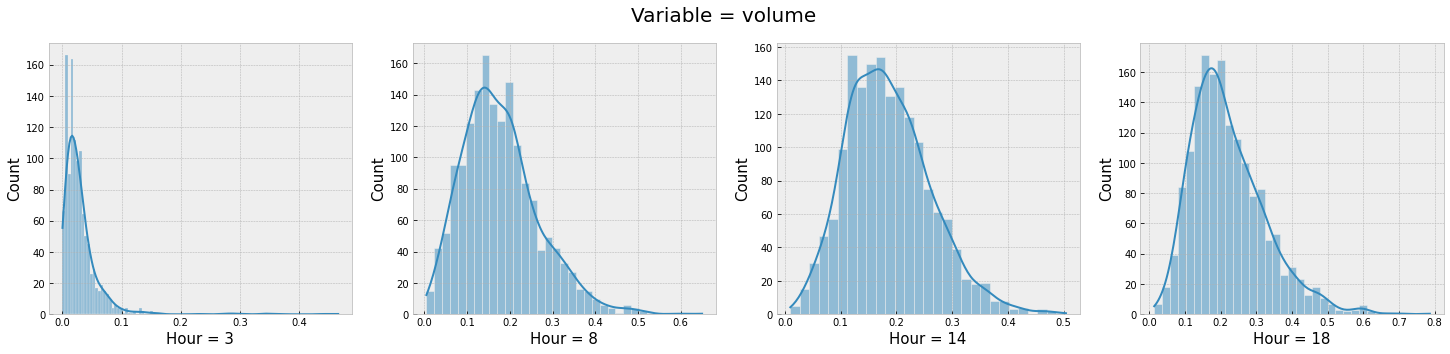

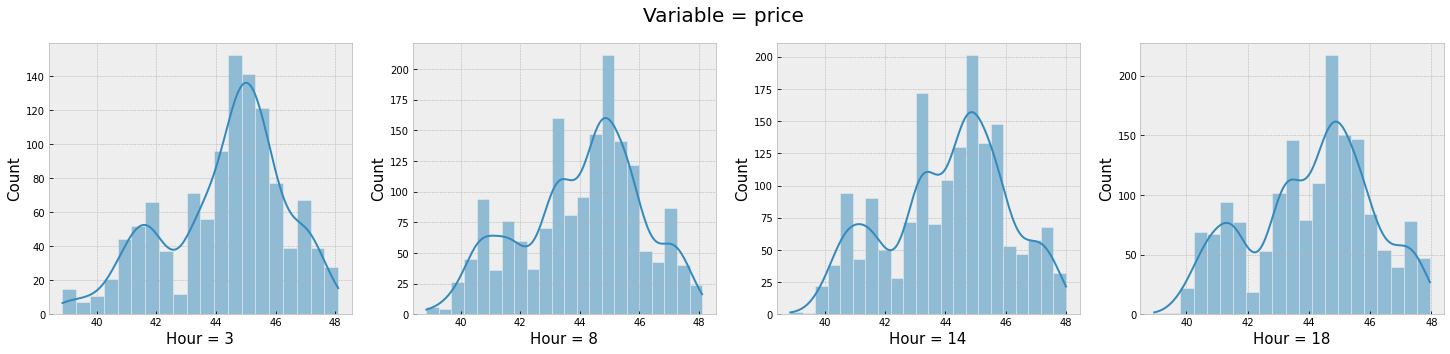

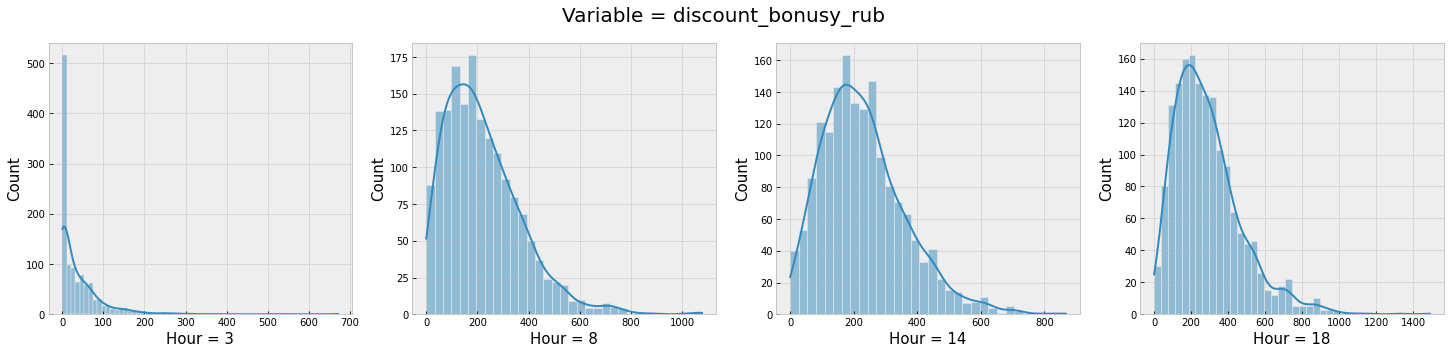

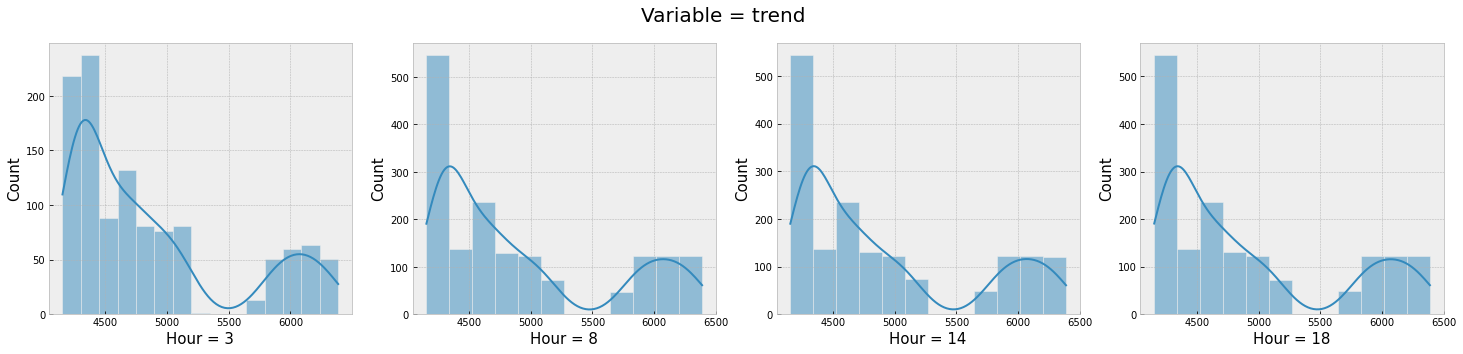

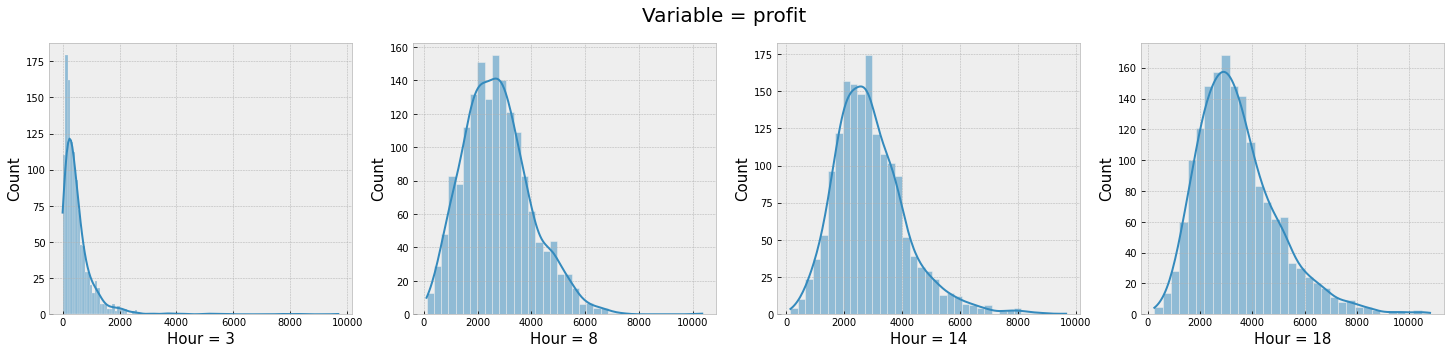

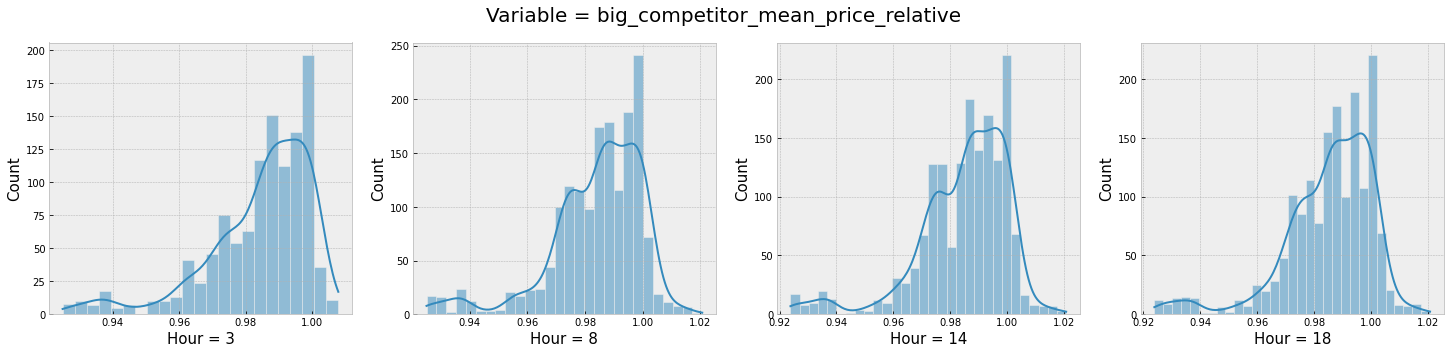

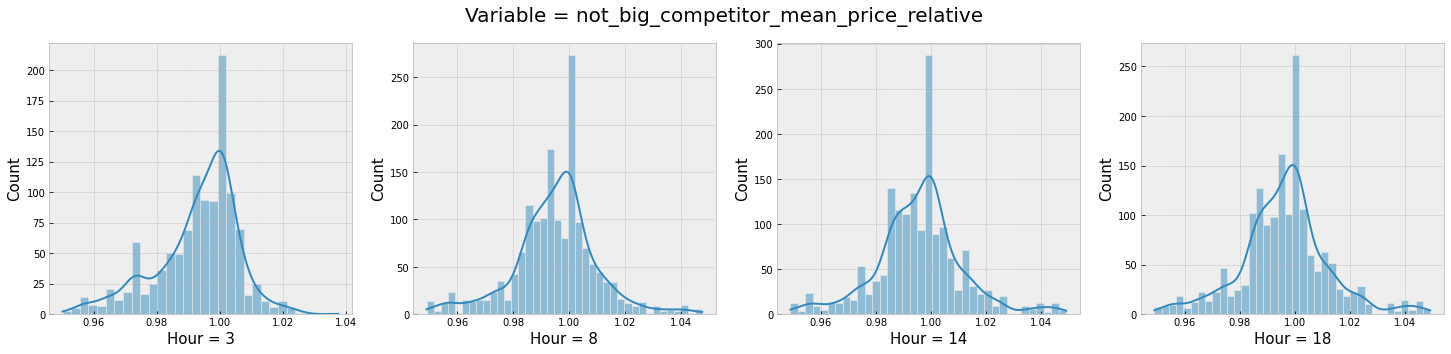

In [12]:
conditions = [3, 8, 14, 18] 

for variable in all_variables:
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    for ax, condition in zip(ax.flat, conditions):

        condition_df = data[data['hour'] == condition]
        sns.histplot(condition_df[variable], ax=ax, kde=True)
        ax.set_xlabel(f'Hour = {condition}', fontsize=15)
        ax.set_ylabel('Count', fontsize=15)
        
    fig.suptitle(f'Variable = {variable}', fontsize=20)
    plt.show()

In [13]:
conditional_mean = pd.DataFrame([], index=all_variables)
conditional_var = pd.DataFrame([], index=all_variables)

for condition in conditions:
    df = data[data['hour'] == condition][all_variables]
    conditional_mean[f'hour = {condition}'] = df.mean(axis=0)
    conditional_var[f'hour = {condition}'] = df.var(axis=0)

In [14]:
conditional_mean

,hour = 3,hour = 8,hour = 14,hour = 18
volume,0.030868,0.177387,0.185821,0.221584
price,44.320964,44.059861,44.082488,44.100513
discount_bonusy_rub,38.177674,219.633571,229.360731,288.105166
trend,4870.032277,4925.107346,4925.931588,4925.451014
profit,536.416729,2717.449376,2914.493813,3441.278616
big_competitor_mean_price_relative,0.984122,0.983966,0.984553,0.985025
not_big_competitor_mean_price_relative,0.992998,0.995043,0.995675,0.996191


In [15]:
conditional_var

,hour = 3,hour = 8,hour = 14,hour = 18
volume,0.001415,8.069048e-03,5.733896e-03,1.077714e-02
price,3.993111,4.001808e+00,3.928645e+00,3.922121e+00
discount_bonusy_rub,3647.592070,2.277426e+04,1.725409e+04,3.339627e+04
trend,452414.830403,5.091558e+05,5.085745e+05,5.089902e+05
profit,508949.824500,1.587096e+06,1.578515e+06,2.372541e+06
big_competitor_mean_price_relative,0.000256,2.665044e-04,2.620952e-04,2.589570e-04
not_big_competitor_mean_price_relative,0.000172,2.290942e-04,2.532393e-04,2.567444e-04


## Step 4

You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

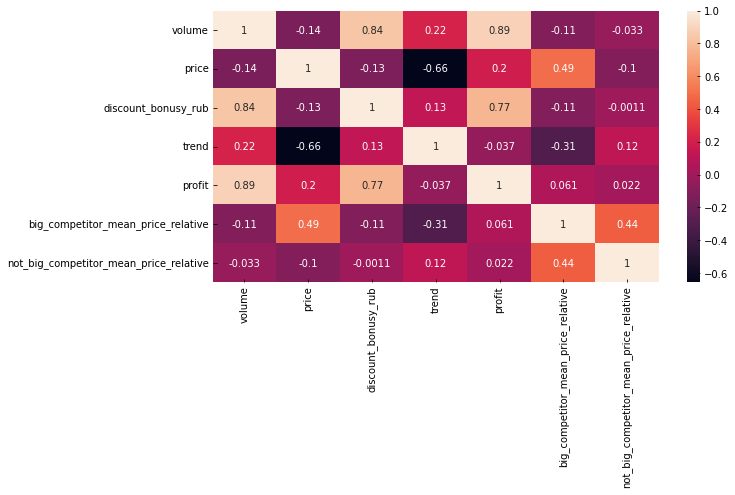

In [16]:
sns.heatmap(data[all_variables].corr(), annot=True)
plt.show()

In [17]:
def calculate_intervals(x, y, alpha=0.05):
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return round(p,4), round(lo,4), round(hi,4)

In [18]:
result_p = pd.DataFrame(index=all_variables, columns=all_variables)
result_intervals = pd.DataFrame(index=all_variables, columns=all_variables)

for v1 in all_variables:
    for v2 in all_variables:
        p, c1, c2 = calculate_intervals(data[v1], data[v2])
        result_p[v1][v2] = p
        r = f'({c1}, {c2})'
        result_intervals[v1][v2] = r

In [19]:
result_p

,volume,price,discount_bonusy_rub,trend,profit,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative
volume,0.0,0.0,0.0,0.0,0.0,0.0,0.0
price,0.0,0.0,0.0,0.0,0.0,0.0,0.0
discount_bonusy_rub,0.0,0.0,0.0,0.0,0.0,0.0,0.8278
trend,0.0,0.0,0.0,0.0,0.0,0.0,0.0
profit,0.0,0.0,0.0,0.0,0.0,0.0,0.0
big_competitor_mean_price_relative,0.0,0.0,0.0,0.0,0.0,0.0,0.0
not_big_competitor_mean_price_relative,0.0,0.0,0.8278,0.0,0.0,0.0,0.0


In [20]:
result_intervals

,volume,price,discount_bonusy_rub,trend,profit,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative
volume,"(1.0, 1.0)","(-0.1502, -0.1304)","(0.8338, 0.8398)","(0.21, 0.2292)","(0.8854, 0.8897)","(-0.1205, -0.1006)","(-0.0435, -0.0234)"
price,"(-0.1502, -0.1304)","(1.0, 1.0)","(-0.1373, -0.1174)","(-0.6624, -0.6509)","(0.1858, 0.2052)","(0.4835, 0.4988)","(-0.113, -0.0931)"
discount_bonusy_rub,"(0.8338, 0.8398)","(-0.1373, -0.1174)","(1.0, 1.0)","(0.1184, 0.1383)","(0.7643, 0.7726)","(-0.1187, -0.0988)","(-0.0112, 0.009)"
trend,"(0.21, 0.2292)","(-0.6624, -0.6509)","(0.1184, 0.1383)","(1.0, 1.0)","(-0.0471, -0.027)","(-0.318, -0.2997)","(0.1101, 0.13)"
profit,"(0.8854, 0.8897)","(0.1858, 0.2052)","(0.7643, 0.7726)","(-0.0471, -0.027)","(1.0, 1.0)","(0.0513, 0.0714)","(0.0121, 0.0322)"
big_competitor_mean_price_relative,"(-0.1205, -0.1006)","(0.4835, 0.4988)","(-0.1187, -0.0988)","(-0.318, -0.2997)","(0.0513, 0.0714)","(1.0, 1.0)","(0.4295, 0.4458)"
not_big_competitor_mean_price_relative,"(-0.0435, -0.0234)","(-0.113, -0.0931)","(-0.0112, 0.009)","(0.1101, 0.13)","(0.0121, 0.0322)","(0.4295, 0.4458)","(1.0, 1.0)"


In [21]:
data[all_variables].corr()

,volume,price,discount_bonusy_rub,trend,profit,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative
volume,1.000000,-0.140325,0.836801,0.219598,0.887556,-0.110532,-0.033432
price,-0.140325,1.000000,-0.127374,-0.656694,0.195541,0.491141,-0.103035
discount_bonusy_rub,0.836801,-0.127374,1.000000,0.128355,0.768467,-0.108736,-0.001119
trend,0.219598,-0.656694,0.128355,1.000000,-0.037063,-0.308876,0.120062
profit,0.887556,0.195541,0.768467,-0.037063,1.000000,0.061330,0.022142
big_competitor_mean_price_relative,-0.110532,0.491141,-0.108736,-0.308876,0.061330,1.000000,0.437673
not_big_competitor_mean_price_relative,-0.033432,-0.103035,-0.001119,0.120062,0.022142,0.437673,1.000000


## Step 5

Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

We need to predict fuel sales, target variable is __volume__, the rest variables are predictors.

We remove variable __profit__ in order to avoid multicollinearity with other features.

In [22]:
data[all_variables].corr().iloc[[0]]

,volume,price,discount_bonusy_rub,trend,profit,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative
volume,1.0,-0.140325,0.836801,0.219598,0.887556,-0.110532,-0.033432


In [23]:
result_intervals.iloc[[0]]

,volume,price,discount_bonusy_rub,trend,profit,big_competitor_mean_price_relative,not_big_competitor_mean_price_relative
volume,"(1.0, 1.0)","(-0.1502, -0.1304)","(0.8338, 0.8398)","(0.21, 0.2292)","(0.8854, 0.8897)","(-0.1205, -0.1006)","(-0.0435, -0.0234)"


## Step 6

Build regression model and make an analysis of multicollinearity and regularization (if needed).

As we have variables in a different scalse lets use StandardScaler

In [25]:
X = ['year', 'month_num', 'day', 'weekday', 'hour','very_cold', 'warm',  
     'trend', 'price',  'discount_bonusy_rub', 
     'big_competitor_mean_price_relative', 'not_big_competitor_mean_price_relative']

X_num = ['trend', 'price',  'discount_bonusy_rub', 
     'big_competitor_mean_price_relative', 'not_big_competitor_mean_price_relative']

y = 'volume'

In [26]:
scaler = MinMaxScaler()
data[X_num] = scaler.fit_transform(data[X_num])

Linear Regression

In [30]:
d_lr = []
mae_lr = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                        data[y], 
                                                        test_size=0.2, 
                                                        random_state=i, 
                                                        shuffle=True)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred = lin_reg.predict(X_test)
    
    d_lr.append(lin_reg.score(X_test, y_test))
    
    mae_lr.append(
        mean_absolute_error(y_test, y_pred))

In [31]:
pd.DataFrame(lin_reg.coef_, index=X, columns=['coefs'])

,coefs
year,-0.006793
month_num,-0.000441
day,0.000090
weekday,-0.000679
hour,0.002050
very_cold,-0.002904
warm,0.004525
trend,0.056411
price,0.033397
discount_bonusy_rub,0.965696


Lasso Regression

In [32]:
d_lasso = []
mae_lasso = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                        data[y], 
                                                        test_size=0.2, 
                                                        random_state=i, 
                                                        shuffle=True)
    
    lasso_reg = LassoCV()
    lasso_reg.fit(X_train, y_train)

    y_pred = lasso_reg.predict(X_test)
    
    d_lasso.append(lasso_reg.score(X_test, y_test))
    
    mae_lasso.append(
        mean_absolute_error(y_test, y_pred))

In [33]:
pd.DataFrame(lasso_reg.coef_, index=X, columns=['coefs'])

,coefs
year,0.001866
month_num,0.000730
day,0.000144
weekday,-0.000713
hour,0.002244
very_cold,-0.001961
warm,0.005175
trend,0.040450
price,0.008167
discount_bonusy_rub,0.909617


Ridge Regression

In [34]:
d_ridge = []
mae_ridge = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                        data[y], 
                                                        test_size=0.2, 
                                                        random_state=i, 
                                                        shuffle=True)
    
    ridge_reg = RidgeCV()
    ridge_reg.fit(X_train, y_train)

    y_pred = ridge_reg.predict(X_test)
    
    d_ridge.append(ridge_reg.score(X_test, y_test))
    
    mae_ridge.append(
        mean_absolute_error(y_test, y_pred))

In [35]:
pd.DataFrame(ridge_reg.coef_, index=X, columns=['coefs'])

,coefs
year,-0.006777
month_num,-0.000438
day,0.000091
weekday,-0.000680
hour,0.002052
very_cold,-0.002901
warm,0.004518
trend,0.056403
price,0.033354
discount_bonusy_rub,0.965066


## Step 7

Analyze the quality of regression model (distribution of residuals, determination coefficient).

In [36]:
print('Linear Regression quality')
print(f'Mean Determination = {round(np.mean(d_lr),3)}')
print(f'Mean MAE = {round(np.mean(mae_lr),3)} \n')

print('Lasso Regression quality')
print(f'Mean Determination = {round(np.mean(d_lasso),3)}')
print(f'Mean MAE = {round(np.mean(mae_lasso),3)} \n')

print('Lasso Regression quality')
print(f'Mean Determination = {round(np.mean(d_ridge),3)}')
print(f'Mean MAE = {round(np.mean(mae_ridge),3)} \n')

Linear Regression quality
Mean Determination = 0.733
Mean MAE = 0.037 

Lasso Regression quality
Mean Determination = 0.73
Mean MAE = 0.038 

Lasso Regression quality
Mean Determination = 0.733
Mean MAE = 0.037 



Best model is Lasso Regression

In [37]:
y_pred = lasso_reg.predict(X_test)

In [38]:
residuals = y_test - y_pred 

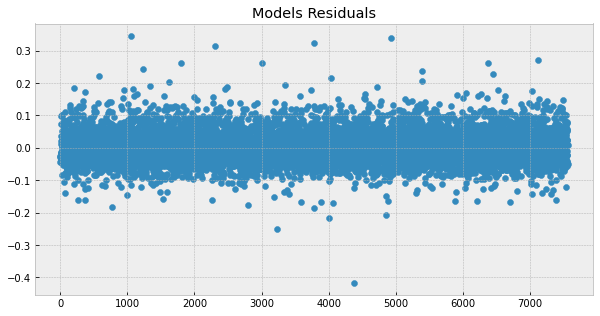

In [39]:
plt.scatter(range(len(residuals)),residuals)
plt.title('Models Residuals')
plt.show()

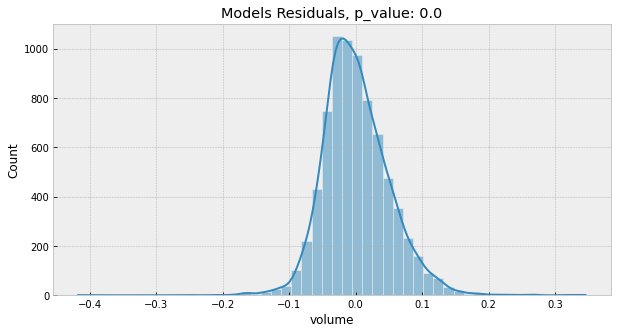

In [40]:
sns.histplot(residuals, bins=50, kde=True)
plt.title(f'Models Residuals, p_value: {round(shapiro(residuals)[1],4)}')
plt.show()

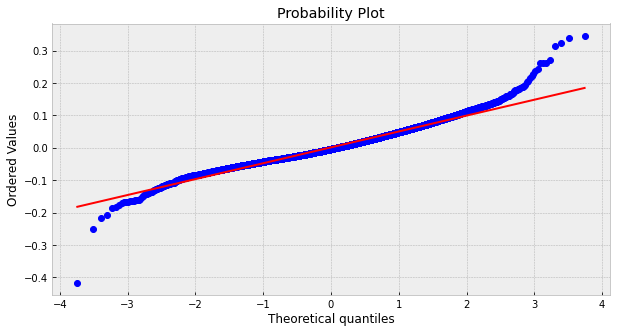

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.style.use('bmh')

qq = probplot(
    residuals.values, 
    dist="norm", 
    plot=ax)

plt.show()